In [182]:
# 모듈, 경로 설정
import pandas as pd
import pydeck as pdk
import geopandas as gpda
import config
import json
import requests
import sys
import folium
import warnings

warnings.filterwarnings(action='ignore')

path = "C:\github/aide-analysis/"
sys.path.append(path)

path2 = "C:\github/prop-tech/"
sys.path.append(path2)
from src.bigquery import bigquery_client, bigquery
from src.visualization import Pydeck
pydeck = Pydeck()
bq = bigquery_client
from core.config import Config
config = Config()

from mapboxgl.viz import *
from mapboxgl.utils import create_color_stops

In [183]:
# 시각화 한글패치
import os
import matplotlib.pyplot as plt

if os.name =='posix':

    plt.rc('font', family = 'AppleGothic')

else:

    plt.rc('font', family = 'Malgun Gothic')

In [184]:
# 매매증감
from src.sql import DatabaseHandler
db = DatabaseHandler()
sql = f"""
SELECT *
FROM aide.kb_weekly_trading_change_rate
WHERE sigunguCode = '28000'
"""
trading = db.read_table(sql)

# 전세증감
from src.sql import DatabaseHandler
db = DatabaseHandler()
sql = f"""
SELECT *
FROM aide.kb_weekly_jeonse_change_rate
WHERE sigunguCode = '28000'
"""
rent = db.read_table(sql)

# 매매, 전세 증감 데이터 합치기
df = pd.merge(trading[['date','tradingChangeRate']], rent[['date', 'jeonseChangeRate']], on = 'date', how = 'inner')

In [185]:
# # 공급양
# from src.bigquery import BigqueryHandler
# BH = BigqueryHandler()
# sql = f"""
# SELECT T1.builtYear,
#     SUM(CAST(T1.fir AS int)) AS fir, 
#     SUM(CAST(T1.second AS int)) AS second,
#     SUM(CAST(T1.third AS int)) AS third, 
#     SUM(CAST(T1.four AS int)) AS four
# FROM(
#         SELECT main.builtYear, 
#             MAX(main.bdongName) AS hdongName, 
#             main.pnuCode,
#             sub.supplyArea,
#             CASE WHEN sub.supplyArea <=60 THEN SUM(sub.sedaeCount) END AS fir,
#             CASE WHEN sub.supplyArea >60 AND sub.supplyArea <= 85 THEN SUM(sub.sedaeCount) END AS second,
#             CASE WHEN sub.supplyArea >85 AND sub.supplyArea <= 135 THEN SUM(sub.sedaeCount) END AS third,
#             CASE WHEN sub.supplyArea >135 THEN SUM(sub.sedaeCount) END AS four,


#         FROM aide.apartment_danji_information AS main
#         INNER JOIN (SELECT bdongCode, pnuCode, supplyArea, sedaeCount
#                     FROM aide.apartment_area_type_information 
#                     WHERE pnuCode LIKE '28%') AS sub
#                     ON main.pnuCode = sub.pnuCode
#         WHERE main.builtYear >=2000
#         GROUP BY main.builtYear, main.pnuCode, sub.supplyArea
#         ORDER BY builtYear
#     ) AS T1
# GROUP BY T1.builtYear
# ORDER BY T1.builtYear

# """
# supply = BH.read_table(sql)
# supply = supply.iloc[8:]

In [186]:
sql = f"""
SELECT  main.builtYear, SUM(sedaeCount) AS sedaeCount
FROM aide.apartment_danji_information AS main
WHERE main.builtYear >=2008
GROUP BY main.builtYear
ORDER BY builtYear
"""
supply2 = BH.read_table(sql)

In [187]:
# 미분양
sql = f"""
SELECT *
FROM aide.unsold_sigungu
WHERE sigunguCode = '28000'
"""
unsold = db.read_table(sql)
unsold = pd.DataFrame(unsold.groupby('year')['unsold'].sum()).reset_index()

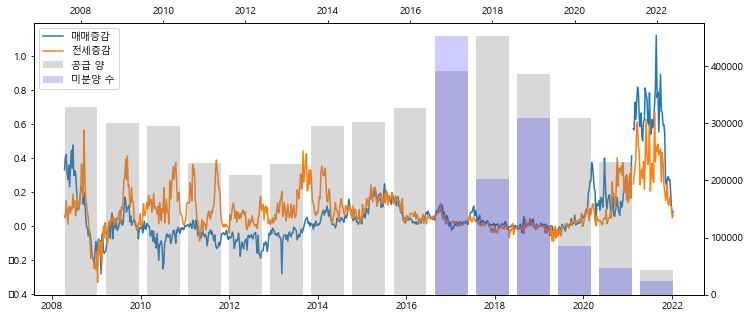

In [188]:
fig, ax = plt.subplots(figsize = (12,5))
# 매매, 전세 증감율
ax.plot(df['date'], df['tradingChangeRate'],label = '매매증감')
ax.plot(df['date'], df['jeonseChangeRate'],label = '전세증감')

# ax2 = ax.twinx().twiny()
# ax2.bar(supply['builtYear'],supply['fir'],color = 'gray',alpha=0.3, label = '공급 양')
# 공급
ax2 = ax.twinx().twiny()
ax2.bar(supply2['builtYear'],supply2['sedaeCount'],color = 'gray',alpha=0.3, label = '공급 양')

# 미분양
ax3= ax2.twinx()
ax3.bar(unsold['year'],unsold['unsold'], color = 'blue', alpha = 0.2, label = '미분양 수')
ax3.axis('off')

# legend handles
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()

# show legend
ax3.legend(lines+lines2+lines3, labels+labels2+labels3, loc ='upper left')

plt.show() 

2021년도에 매매와 전세가가 모두 급상승을 했는데 이때의 미분양과 공급양을 보게되면 2020년 공급이 상당수 됬음에도 총 미분양이 반이상 줄었으며 21년도에는 공급이 거의 없었으며 미분양 역시 더욱 줄었다 이것만이 가격상승의 단일 요인은 되지 않지만 상당히 영향이 있었을것으로 추정된다. (추가적으로 정보 찾아보기)

또한 하지만 2022년의 경우 4월까지의 데이터 임에도 불구하고 이전해인 2021년보다 공급이 벌써 2배이상 늘었으며, 미분양 역시 작년의 절반이나 따라잡았다. 이것이 가격 하락의 영향이 있을것으로 추측

최근 6개월 흐름으로 확대해서 분석

In [170]:
# 미분양
sql = f"""
SELECT *
FROM aide.unsold_sigungu
WHERE sigunguCode = '28000' AND ((year = 2021 and month >= 10) OR (year =2022 ))
"""
unsold = db.read_table(sql)
unsold['date'] = pd.to_datetime(unsold['date']).dt.strftime('%Y-%m')

In [171]:
# 공급양
from src.bigquery import BigqueryHandler
BH = BigqueryHandler()
sql = f"""
SELECT  main.usePermissionDate , SUM(main.sedaeCount) AS sedaeCount
FROM aide.apartment_danji_information AS main
WHERE main.builtYear >=2021 AND sidoCode = '28'
GROUP BY main.builtYear, main.usePermissionDate
ORDER BY builtYear, usePermissionDate
"""
supply = BH.read_table(sql)
supply['usePermissionDate'] = pd.to_datetime(supply['usePermissionDate'],format = '%Y-%m-%d').dt.strftime('%Y-%m')
supply = pd.DataFrame(supply.groupby('usePermissionDate')['sedaeCount'].sum()).reset_index()

In [172]:
date = unsold['date']
date = pd.DataFrame(date)
supply = pd.merge(date, supply, left_on = 'date', right_on = 'usePermissionDate', how = 'left')[['date','sedaeCount']]

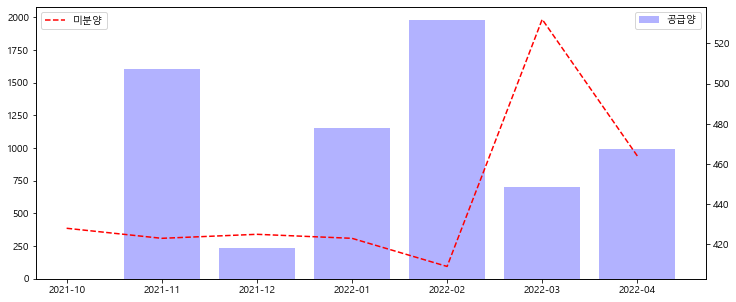

In [173]:
fig,ax = plt.subplots(figsize = (12,5))

ax.bar(supply['date'], supply['sedaeCount'],color = 'blue', label = '공급양', alpha = 0.3)
ax2 = ax.twinx()
ax2.plot(unsold['date'],unsold['unsold'],color = 'red', label = '미분양',linestyle ='--')

ax.legend()
ax2.legend(loc='upper left')
plt.show()